<a href="https://colab.research.google.com/github/yulee-research/ImageGraph/blob/Try01/aortaTry01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>]
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>]
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>]
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>]
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>]
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([300,   8,   8,   1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array

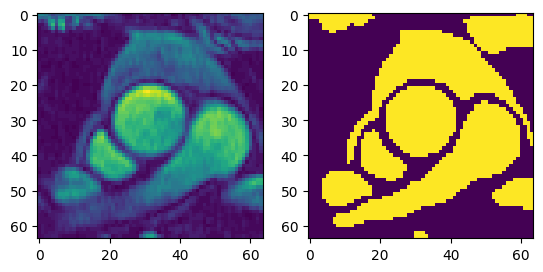

In [5]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

trainData=loadmat('/content/drive/MyDrive/ImageGraph/aortaMag1Ph10Pt150.mat')
ImgC1=np.array(trainData['roiMagC'],dtype=np.float32)
ImgM1=np.sum(np.array(trainData['roiMask'],dtype=np.float32),axis=2)
fig, (ax1,ax2)=plt.subplots(1,2)
ax1.imshow(ImgC1)
ax2.imshow(ImgM1)

# Divide the images into multiple patches

nrow,ncol=ImgC1.shape
nxpatch,nypatch=(8,8)
trainImgC=tf.convert_to_tensor(np.array([ImgC1[i:i+nypatch,j:j+nypatch] for i in range(nrow-nxpatch) for j in range(ncol-nypatch)]).reshape((-1,nxpatch,nypatch,1)))
trainImgM=tf.convert_to_tensor(np.array([ImgM1[i:i+nypatch,j:j+nypatch] for i in range(nrow-nxpatch) for j in range(ncol-nypatch)]).reshape((-1,nxpatch,nypatch,1)))

train_ds=tf.data.Dataset.from_tensor_slices((trainImgC,trainImgM)).shuffle(600).batch(300)

# print(patchImgC.shape)
# print(patchImgM.shape)
# fig,(ax1,ax2)=plt.subplots(1,2)
# ax1.imshow(patchImgC[:16,:,:].transpose((1,0,2)).reshape((nxpatch*1,nypatch*16)))
# ax2.imshow(patchImgM[:16,:,:].transpose((1,0,2)).reshape((nxpatch*1,nypatch*16)))

for images,labels in train_ds:
  print([tf.shape(images),tf.shape(labels)])

In [3]:
pip install mat73

[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([64,  8,  8,  1], dtype=int32)>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([64,  8,  8,  1], dtype=int32)>]


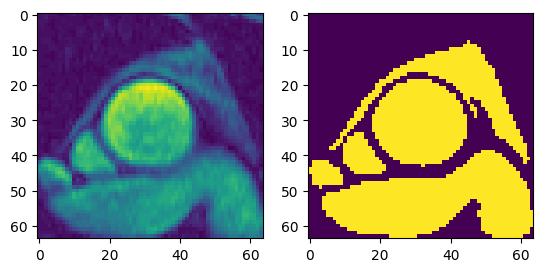

In [13]:
import mat73
testData=mat73.loadmat('/content/drive/MyDrive/ImageGraph/aortaMag1Ph10Pt151.mat')
ImgC2=np.array(testData['roiMagC'],dtype=np.float32)
ImgM2=np.sum(np.array(testData['roiMask'],dtype=np.float32),axis=2)
fig, (ax1,ax2)=plt.subplots(1,2)
ax1.imshow(ImgC2)
ax2.imshow(ImgM2)

# Divide the images into multiple patches

nrow,ncol=ImgC2.shape
nxpatch,nypatch=(8,8)
seqx=[i*nxpatch for i in range(nrow//nxpatch)]
seqy=[i*nypatch for i in range(ncol//nypatch)]
testImgC=tf.convert_to_tensor(np.array([ImgC2[i:i+nypatch,j:j+nypatch] for i in seqx for j in seqy]).reshape(-1,nxpatch,nypatch,1))
testImgM=tf.convert_to_tensor(np.array([ImgM2[i:i+nypatch,j:j+nypatch] for i in seqx for j in seqy]).reshape(-1,nxpatch,nypatch,1))
test_ds=tf.data.Dataset.from_tensor_slices((testImgC,testImgM)).batch(len(seqx)*len(seqy))

for images,labels in test_ds:
  print([tf.shape(images),tf.shape(labels)])

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate, Flatten, Softmax
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1e=Conv2D(16, 3, activation='relu',padding='same')
    self.conv1d=Conv2D(8, 3, activation='relu',padding='same')
    self.conv0d=Conv2D(1, 1, padding='same',activation='sigmoid')  # output
    self.conv2d=Conv2D(4, 1, padding='same')
    self.flat=Flatten()
    self.resh1=Reshape((8,8,16))
    self.resh2=Reshape((4,4,4))
    self.comb=Concatenate()
    self.fcnn1e=Dense(4*4*4, activation='relu')
    self.fcnn2e=Dense(16, activation='relu')
    self.fcnn2d=Dense(4*4*4, activation='relu')
    self.fcnn1d=Dense(8*8*16, activation='relu')

  def call(self, x):
    x1e = self.conv1e(x)
    x1eF=self.flat(x1e)
    x2eF=self.fcnn1e(x1eF)
    x2e=self.resh2(x2eF)
    x3eF=self.fcnn2e(x2eF)
    x2dF=self.fcnn2d(x3eF)
    x2d=self.resh2(x2dF)
    x2dC=self.comb([x2e,x2d])
    x2dC=self.conv2d(x2dC)
    x2dCF=self.flat(x2dC)
    x1dF=self.fcnn1d(x2dCF)
    x1d=self.resh1(x1dF)
    x1dC=self.comb([x1e,x1d])
    x1dC=self.conv1d(x1dC)
    y=self.conv0d(x1dC)
    return y

# Create an instance of the model
model=MyModel()

loss_object=tf.keras.losses.MeanSquaredError(name='MeanSqureLoss')
optimizer=tf.keras.optimizers.Adam()

train_loss=tf.keras.metrics.Mean(name='TrainLoss')
test_loss=tf.keras.metrics.Mean(name='TestLoss')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    pred=model(images,training=True)
    loss=loss_object(labels,pred)
  gradients=tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)

@tf.function
def test_step(images,labels):
  pred=model(images,training=False)
  loss=loss_object(labels,pred)
  test_loss(loss)

  #return pred

In [22]:
from scipy.io import savemat
# import os

# checkpointPath="/content/drive/MyDrive/aortaTrainingCheckpoint/model.ckpt"
# # os.listdir(os.path.dirname(checkpointPath))

EPOCHS=100

for epoch in range(EPOCHS):
  train_loss.reset_states()
  test_loss.reset_states()
  for images, labels in train_ds:
    # print([tf.shape(images),tf.shape(labels)])
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    #print([tf.shape(test_images),tf.shape(test_labels)])
    pred=test_step(test_images, test_labels)

  print(
      f'Epoch {epoch + 1}. '
      f'Loss: {train_loss.result()}, '
      f'Test loss: {test_loss.result()}'
  )



Epoch 1. Loss: 0.000678877579048276, Test loss: 0.08608577400445938
Epoch 2. Loss: 0.0006403965526260436, Test loss: 0.08622603863477707
Epoch 3. Loss: 0.0006386643508449197, Test loss: 0.08601592481136322
Epoch 4. Loss: 0.0006606956594623625, Test loss: 0.08607911318540573
Epoch 5. Loss: 0.0006323786801658571, Test loss: 0.08625774085521698
Epoch 6. Loss: 0.0006486179772764444, Test loss: 0.08616190403699875
Epoch 7. Loss: 0.0006434112438000739, Test loss: 0.08616270124912262
Epoch 8. Loss: 0.0006456843693740666, Test loss: 0.08619700372219086
Epoch 9. Loss: 0.0006573963328264654, Test loss: 0.08634789288043976
Epoch 10. Loss: 0.0006362635758705437, Test loss: 0.08604075759649277
Epoch 11. Loss: 0.0006358985556289554, Test loss: 0.08624294400215149
Epoch 12. Loss: 0.0006345545989461243, Test loss: 0.08621880412101746
Epoch 13. Loss: 0.0006577178719453514, Test loss: 0.0862341821193695
Epoch 14. Loss: 0.0006452826783061028, Test loss: 0.08619639277458191
Epoch 15. Loss: 0.0006338448729

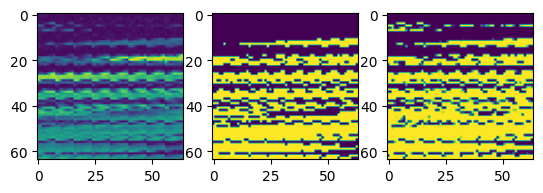

In [23]:
pred=model(test_images,training=False)
testMagC=test_images.numpy().reshape((nrow,ncol))
testLabC=test_labels.numpy().reshape((nrow,ncol))
testPred=pred.numpy().reshape((nrow,ncol))

fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(testMagC)
ax2.imshow(testLabC)
ax3.imshow(testPred)

matData={"testMagC":testMagC, "testLabC":testLabC, "testPred":testPred}
savemat("/content/drive/MyDrive/ImageGraph/test_results.mat",matData)

tf.saved_model.save(model,'/content/drive/MyDrive/ImageGraph/aortaModel')